In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from scipy.stats import cauchy
import random
import sympy as sp
from scipy.optimize import fsolve

In [2]:
def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 


# Simulation

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


Chi measure (synchrony): 0.032598254278430924
Average firing rate 31.850000000000005


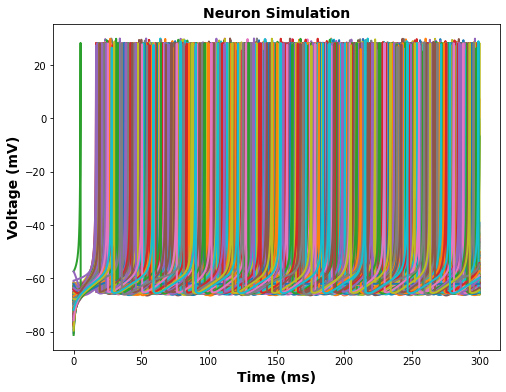

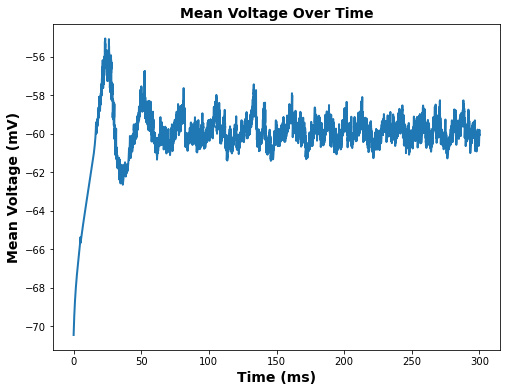

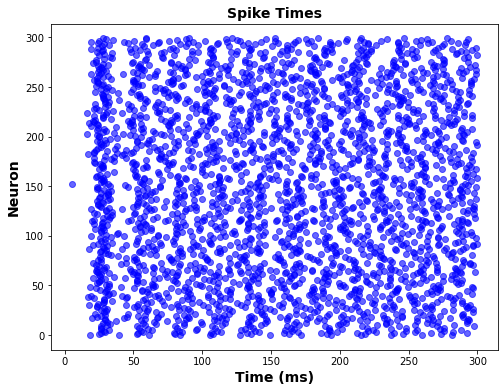

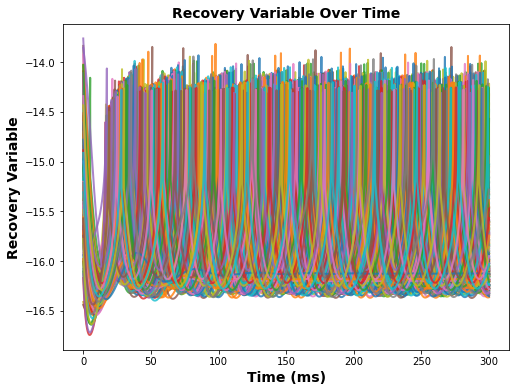

In [4]:
# Sparsely Connected
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033)/N #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('NeuronModel.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('MeanVoltage.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('SpikeTimes.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('RecoveryVariable.png')

# Extract the voltage traces (first N rows of y_all)
voltage_data = y_all[:N, :]  # Shape: (N, time_steps)
# Compute the Chi measure
chi_value = compute_chi(voltage_data)

# Print the Chi measure
print(f"Chi measure (synchrony): {chi_value}")


average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

Chi measure (synchrony): 0.04370545255748103
Average firing rate 32.620000000000005


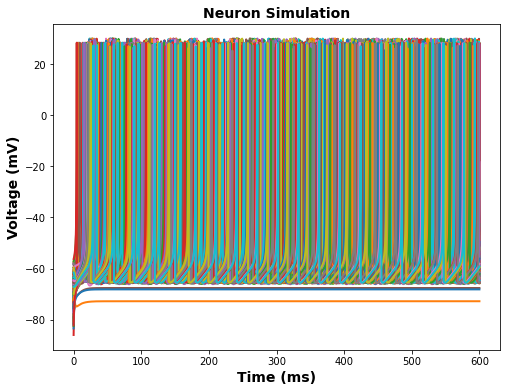

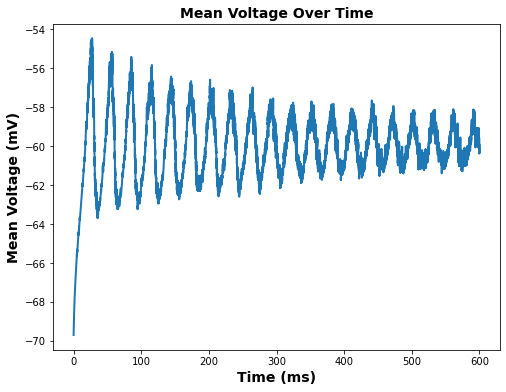

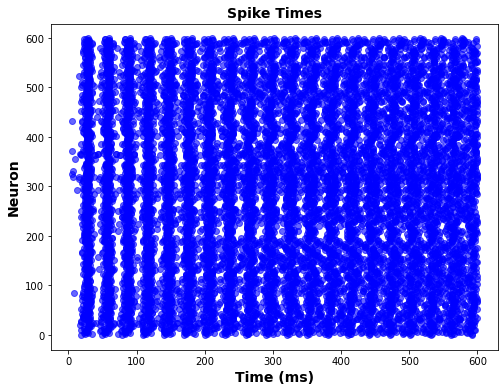

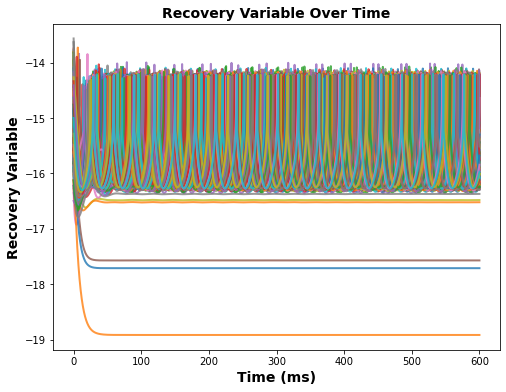

In [10]:
# All to all Connected J=lorentzian
np.random.seed(101)

N = 600
T = 600
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30
#v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = stats.cauchy.rvs(loc=0.0, scale=0.01, size=N)

I = 0.33

# # Define desired average number of connections
# Avg_Connections = 40
# connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# # Sparsely connected networks with probabilistic connections
# for j in range(N):
#     for i in range(N):
#         if i != j:  # Avoid self-connections
#             if np.random.rand() < connection_probability:
#                 g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
g = np.random.normal(0.003959666666666666, 0, size = (N,N))            
np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033)/N #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('NeuronModel.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('MeanVoltage.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('SpikeTimes.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('RecoveryVariable.png')

# Extract the voltage traces (first N rows of y_all)
voltage_data = y_all[:N, :]  # Shape: (N, time_steps)
# Compute the Chi measure
chi_value = compute_chi(voltage_data)

# Print the Chi measure
print(f"Chi measure (synchrony): {chi_value}")


average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

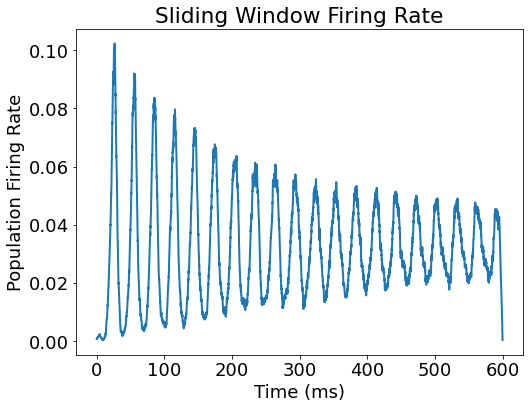

Mean Firing Rate: 32.08311111111111 Hz


In [122]:
def compute_sliding_window_firing_rate(spike_times, N, T,
                                       window_size=10,  # ms
                                       step_size=0.05):  # ms
    
    # All spike times (in ms) in sorted order:
    spike_t = spike_times[:, 0]
    # Ensure sorted by time (if not already)
    spike_t_sorted = np.sort(spike_t)

    # We will collect time bins from 0 to T in increments of step_size
    time_bins = np.arange(0, T, step_size)
    fr_array = np.zeros_like(time_bins)

    # Convert ms to s for rates in Hz:
    ms_to_s = 1

    for i, t_start in enumerate(time_bins):
        t_end = t_start + window_size
        # Count how many spikes occurred in [t_start, t_end)
        # "spikes_in_win" is how many spike times fall in that interval
        mask = (spike_t_sorted >= t_start) & (spike_t_sorted < t_end)
        num_spikes_in_window = np.sum(mask)

        # Window duration in seconds
        w_sec = window_size * ms_to_s

        # Rate in spikes/(neuron·second) a.k.a. Hz:
        fr_array[i] = num_spikes_in_window / (N * w_sec)

    return time_bins, fr_array

valid_spikes = spike_times[:spikeCounter, :]  # shape (actual_spike_count, 2)

time_bins, fr_array = compute_sliding_window_firing_rate(valid_spikes, N, T,
                                                         window_size=5,
                                                         step_size=0.05)

plt.figure(figsize=(8,6))
plt.plot(time_bins, fr_array, lw=2)
plt.xlabel("Time (ms)")
plt.ylabel("Population Firing Rate")  # if used ms->s conversion
plt.title("Sliding Window Firing Rate")
plt.show()

mean_firing_rate = np.mean(fr_array)
print(f"Mean Firing Rate: {mean_firing_rate*1e3} Hz")

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


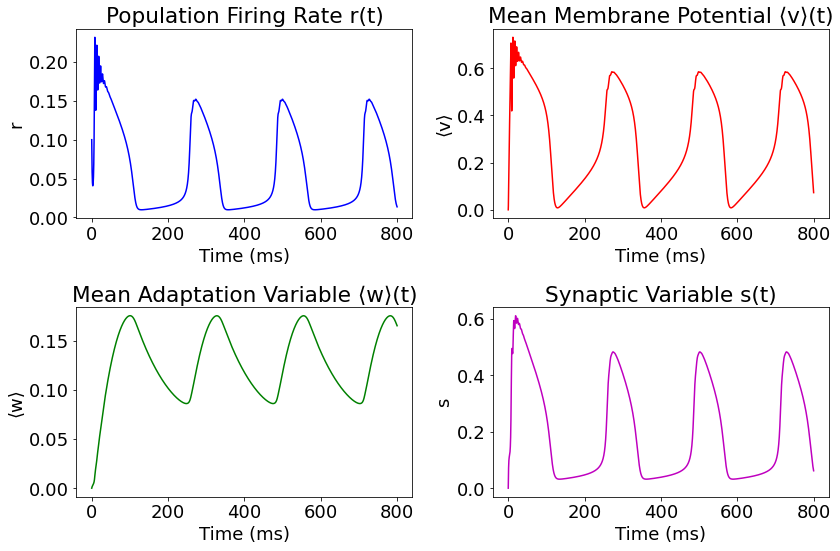

In [6]:


# Define the dimensionless parameters from Campbell–Izhikevich paper
alpha   = 0.6215      # intrinsic parameter
tau_s   = 2.6        # synaptic time constant
g_syn   = 1.2308      # synaptic coupling strength
a       = 0.0077      # adaptation parameter
b       = -0.0062     # adaptation sensitivity
s_jump  = 1.2308      # synaptic jump on a spike
w_jump  = 0.0189      # adaptation jump on a spike
e_r     = 1        # synaptic reversal potential
I_ext   = 0         # external applied current

# Heterogeneity parameters for the intrinsic current eta
Delta_eta = 0.02      # half-width of Lorentzian for eta
eta_bar   = 0.12      # mean intrinsic current

pi = np.pi

# Define the mean-field ODE system
def mean_field_odes(t, y):
    r, v_mean, w_mean, s = y
    drdt  = Delta_eta / pi + 2 * r * v_mean - (alpha + g_syn * s) * r
    dvdt  = v_mean**2 - alpha * v_mean - w_mean + eta_bar + I_ext + g_syn * s * (e_r - v_mean) - (pi**2) * r**2
    dwdt  = a * (b * v_mean - w_mean) + w_jump * r
    dsdt  = - s / tau_s + s_jump * r
    return [drdt, dvdt, dwdt, dsdt]

# Set simulation parameters
t_span = (0, 800)  # simulate for 300 ms
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Initial conditions for [r(0), ⟨v⟩(0), ⟨u⟩(0), s(0)]
y0 = [0.1,0 , 0, 0]

# Solve the ODE system
sol = solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(sol.t, sol.y[0], 'b')
plt.title('Population Firing Rate r(t)')
plt.xlabel('Time (ms)')
plt.ylabel('r')

plt.subplot(2, 2, 2)
plt.plot(sol.t, sol.y[1], 'r')
plt.title('Mean Membrane Potential ⟨v⟩(t)')
plt.xlabel('Time (ms)')
plt.ylabel('⟨v⟩')

plt.subplot(2, 2, 3)
plt.plot(sol.t, sol.y[2], 'g')
plt.title('Mean Adaptation Variable ⟨w⟩(t)')
plt.xlabel('Time (ms)')
plt.ylabel('⟨w⟩')

plt.subplot(2, 2, 4)
plt.plot(sol.t, sol.y[3], 'm')
plt.title('Synaptic Variable s(t)')
plt.xlabel('Time (ms)')
plt.ylabel('s')

plt.tight_layout()
plt.show()


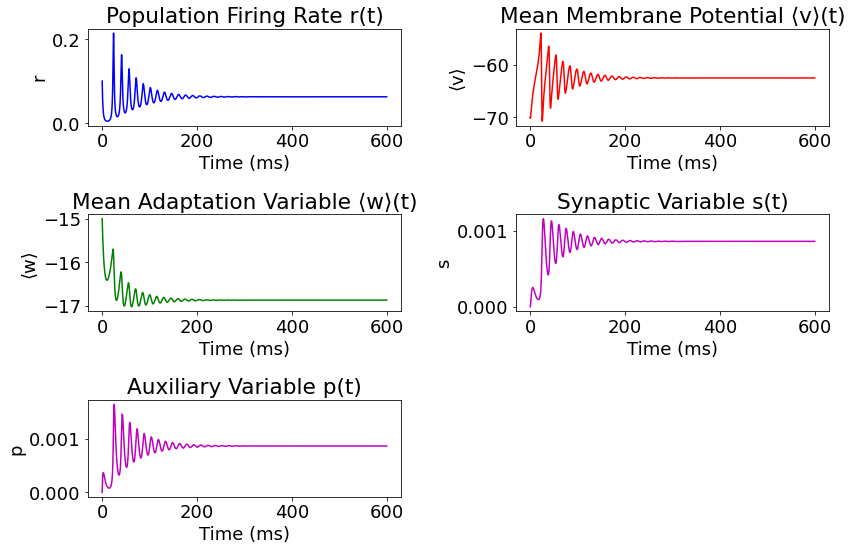

In [124]:

N = 600
A = 0.04
B = 5
C = 140
# Define the dimensionless parameters from Campbell–Izhikevich paper
tau_s   = 3.043043043043043        # synaptic time constant
#gsyn = 0.03
gsyn   =  0.003959666666666666    # synaptic coupling strength
a       = 0.1      # adaptation parameter
b       = 0.26     # adaptation sensitivity
p_jump  = (2.7185823035951033)/N      # synaptic jump on a spike
d_jump  =  -1     # adaptation jump on a spike
Esyn    = -70        # synaptic reversal potential
Iext   = .33         # external applied current

# Heterogeneity parameters for the intrinsic current eta
Delta = 0      # half-width of Lorentzian for eta
etaBar   = 0.01      # mean intrinsic current

pi = np.pi

# Define the mean-field ODE system
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - gsyn*s)*r + 2.0*A*r*v +  Delta*A/pi
    dvdt = (- (pi**2 / A)*(r**2) + A*(v**2) + C - u + (B - gsyn*s)*v + Iext + etaBar + gsyn*s*(Esyn - v))
    dudt = (a*(b*v - u) + d_jump*r)
    dsdt = (- s / tau_s + p / tau_s)
    dpdt = (-(p/tau_s) + p_jump*r)
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set simulation parameters
t_span = (0, 600)  # simulate for 300 ms
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Initial conditions for [r(0), ⟨v⟩(0), ⟨u⟩(0), s(0)]
y0 = [0.1, -70, -15, 0, 0]

# Solve the ODE system
sol = solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(sol.t, sol.y[0], 'b')
plt.title('Population Firing Rate r(t)')
plt.xlabel('Time (ms)')
plt.ylabel('r')

plt.subplot(3, 2, 2)
plt.plot(sol.t, sol.y[1], 'r')
plt.title('Mean Membrane Potential ⟨v⟩(t)')
plt.xlabel('Time (ms)')
plt.ylabel('⟨v⟩')

plt.subplot(3, 2, 3)
plt.plot(sol.t, sol.y[2], 'g')
plt.title('Mean Adaptation Variable ⟨w⟩(t)')
plt.xlabel('Time (ms)')
plt.ylabel('⟨w⟩')

plt.subplot(3, 2, 4)
plt.plot(sol.t, sol.y[3], 'm')
plt.title('Synaptic Variable s(t)')
plt.xlabel('Time (ms)')
plt.ylabel('s')

plt.subplot(3, 2, 5)
plt.plot(sol.t, sol.y[4], 'm')
plt.title('Auxiliary Variable p(t)')
plt.xlabel('Time (ms)')
plt.ylabel('p')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Mean Voltage Over Time')

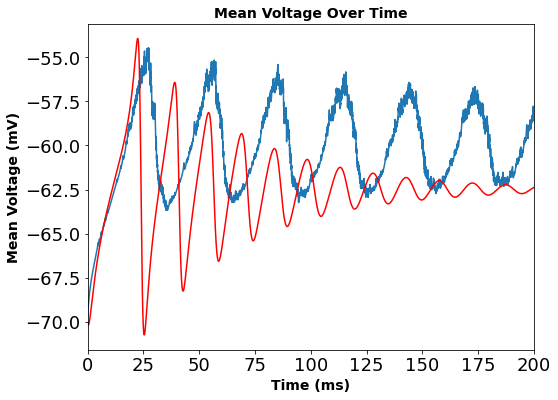

In [91]:
# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.xlim(0,200)
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.plot(sol.t, sol.y[1], 'r')
plt.title('Mean Membrane Potential ⟨v⟩(t)')
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')

Text(0, 0.5, '⟨w⟩')

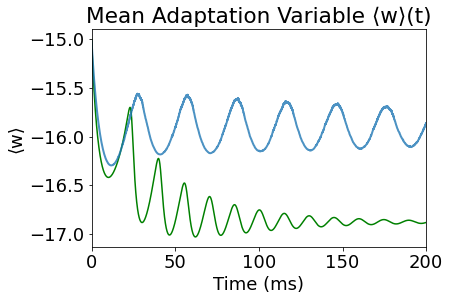

In [92]:
plt.plot(sol.t, sol.y[2], 'g')
plt.plot(t_all, y_all[N:2*N, :].mean(axis=0), linewidth=2, alpha=0.8)
plt.xlim(0,200)
plt.title('Mean Adaptation Variable ⟨w⟩(t)')
plt.xlabel('Time (ms)')
plt.ylabel('⟨w⟩')

60.89681371018743 Hz
32.08311111111111 Hz


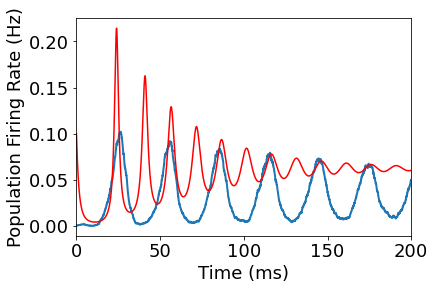

In [131]:
# Plot the mean field firing rate vs sliding window from network
plt.plot(time_bins, fr_array, lw=2)
plt.plot(sol.t, sol.y[0], color = 'red')
plt.xlabel("Time (ms)")
plt.xlim(0,200)
plt.ylabel("Population Firing Rate (Hz)")
print(sol.y[0].mean(axis=0)*1e3, "Hz")
print(np.mean(fr_array)*1e3, "Hz")

In [61]:

# Declare unknowns
r, v, u, s, p = sp.symbols('r v u s p', real=True)

# Plug in your known constants
N     = 600
A     = 0.04
B     = 5
C     = 140
tau_s = 3.043043043043043
gsyn  = 0.003959666666666666
a     = 0.1
b     = 0.26
p_jump = 2.7185823035951033 / N
d_jump = -1
Esyn  = -70
Iext  = 0.33
Delta = 0
etaBar= 0.01

pi_ = sp.pi

# Define the equations f_i=0:
f1 = (B - gsyn*s)*r + 2.0*A*r*v + Delta*A/pi_
f2 = (-(pi_**2 / A)*r**2 + A*(v**2) + C - u
      + (B - gsyn*s)*v + Iext + etaBar
      + gsyn*s*(Esyn - v))
f3 = (a*(b*v - u) + d_jump*r)
f4 = (- s/tau_s + p/tau_s)
f5 = (- p/tau_s + p_jump*r)

eqs = [f1, f2, f3, f4, f5]

# Symbolically solve
solutions = sp.solve([sp.Eq(expr, 0) for expr in eqs],
                     [r, v, u, s, p],
                     dict=True)

print("Fixed Point Solutions:")
for i, sol in enumerate(solutions, start=1):
    print(f"Solution {i}:\n", sol, "\n")


Fixed Point Solutions:
Solution 1:
 {r: 0.0, v: -60.6861406616345, u: -15.7783965720250, s: 0.0, p: 0.0} 

Solution 2:
 {r: 0.0, v: -57.8138593383655, u: -15.0316034279750, s: 0.0, p: 0.0} 



In [63]:
F1 = (B - gsyn*s)*r + 2.0*A*r*v + Delta*A/pi_  # = dr/dt
F2 = (-(pi_**2 / A)*r**2 + A*(v**2) + C - u
      + (B - gsyn*s)*v + Iext + etaBar
      + gsyn*s*(Esyn - v))                    # = dv/dt
F3 = (a*(b*v - u) + d_jump*r)                  # = du/dt
F4 = (- s/tau_s + p/tau_s)                     # = ds/dt
F5 = (- p/tau_s + p_jump*r)                    # = dp/dt

F = sp.Matrix([F1, F2, F3, F4, F5])

# Then form the Jacobian w.r.t. [r,v,u,s,p].
J = F.jacobian([r, v, u, s, p])

print("\nSymbolic Jacobian:\n", J)



Symbolic Jacobian:
 Matrix([[-0.00395966666666667*s + 0.08*v + 5, 0.08*r, 0, -0.00395966666666667*r, 0], [-50.0*pi**2*r, -0.00791933333333333*s + 0.08*v + 5, -1, -0.00791933333333333*v - 0.277176666666667, 0], [-1, 0.0260000000000000, -0.100000000000000, 0, 0], [0, 0, 0, -0.328618421052632, 0.328618421052632], [0.00453097050599184, 0, 0, 0, -0.328618421052632]])


In [65]:
# Evaluate the Jacobian at this particular solution
J_sub = J.subs(sol)
J_eval = J_sub.evalf()

# Get eigenvalues from eigenvects (returns [(eigenvalue, multiplicity, eigenvector), ...])
evects = J_eval.eigenvects()

# Extract just the eigenvalues (each entry in evects is (lambda, mult, [vector,...]))
eigenvals = [ev[0] for ev in evects]

print("Eigenvalues:")
for eig in eigenvals:
    print(eig)


Eigenvalues:
-0.328618421052632 - 3.24633905818974e-34*I
0.0225543735346195 - 0.104787525629423*I
0.0225543735346195 + 0.104787525629423*I
0.145108747069239
-0.328618421052632


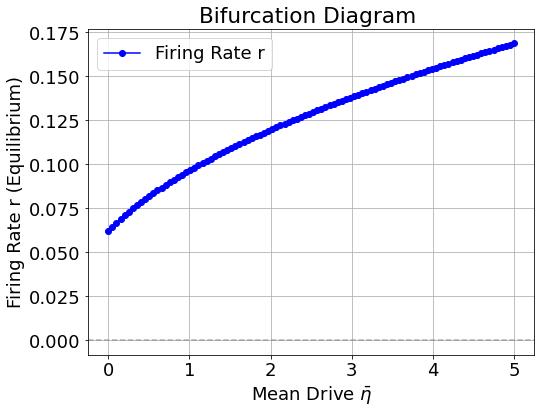

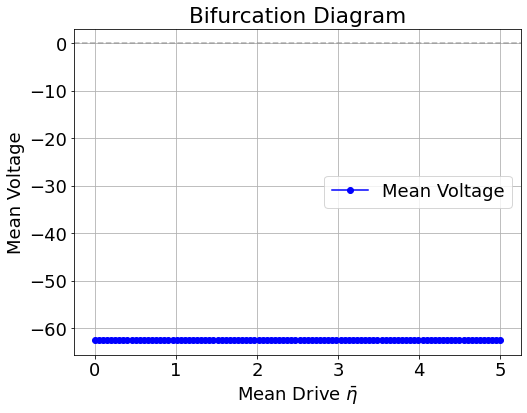

In [66]:
# Define symbolic variables
r, v, u, s, p = sp.symbols('r v u s p', real=True)
etaBar_sym, Delta_eta_sym = sp.symbols('etaBar Delta_eta', real=True)

# Define system equations for steady state (dr/dt = dv/dt = du/dt = ds/dt = dp/dt = 0)
eq1 = (B - gsyn*s)*r + 2.0*A*r*v + Delta_eta_sym*A/pi
eq2 = (- (pi**2 / A)*(r**2) + A*(v**2) + C - u + (B - gsyn*s)*v + Iext + etaBar_sym + gsyn*s*(Esyn - v))
eq3 = (a*(b*v - u) + d_jump*r)
eq4 = (- s / tau_s + p / tau_s)
eq5 = (-(p/tau_s) + p_jump*r)

# Solve for steady-state solutions in terms of etaBar and Delta_eta
steady_state_eqs = [eq1, eq2, eq3, eq4, eq5]

# Convert equations to a numerical function for fsolve
def fixed_point_system(vars, etaBar_val, Delta_eta_val):
    r_, v_, u_, s_, p_ = vars
    return [
        (B - gsyn*s_)*r_ + 2.0*A*r_*v_ + Delta_eta_val*A/pi,
        - (pi**2 / A)*(r_**2) + A*(v_**2) + C - u_ + (B - gsyn*s_)*v_ + Iext + etaBar_val + gsyn*s_*(Esyn - v_),
        a*(b*v_ - u_) + d_jump*r_,
        (- s_ / tau_s + p_ / tau_s),
        (-(p_/tau_s) + p_jump*r_)
    ]

# Define parameter ranges for bifurcation analysis
etaBar_values = np.linspace(0, 5, 100)
# Store bifurcation points
r_solutions = []
v_solutions = []

# Solve for equilibrium points at each etaBar value
initial_guess = [0.1, -70, -15, 0, 0]  # Initial guess for solver
for etaBar_val in etaBar_values:
    sol = fsolve(fixed_point_system, initial_guess, args=(etaBar_val, 0.0))  # Fix Delta_eta = 0
    r_solutions.append(sol[0])  # Store firing rate
    v_solutions.append(sol[1])  # Store membrane potential
    initial_guess = sol  # Use previous solution as new guess

# Plot bifurcation diagram (etaBar vs. firing rate)
plt.figure(figsize=(8, 6))
plt.plot(etaBar_values, r_solutions, 'bo-', label="Firing Rate r")
plt.xlabel(r"Mean Drive $\bar{\eta}$")
plt.ylabel("Firing Rate r (Equilibrium)")
plt.title("Bifurcation Diagram ")
plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.grid()
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(etaBar_values, v_solutions, 'bo-', label="Mean Voltage")
plt.xlabel(r"Mean Drive $\bar{\eta}$")
plt.ylabel("Mean Voltage")
plt.title("Bifurcation Diagram")
plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.grid()
plt.legend()
plt.show()
